In [ ]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.cluster import KMeans
from scipy.spatial import distance
import math
import numpy as np
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [ ]:
# load and split the data
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.boston_housing.load_data(test_split=0.25)
Xtrain, Xval, ytrain, yval=train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)

# we can also standarize the data (mean = 0 and std = 1)
# we only fit the scaler in train data, so we dont have data leakage 
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xval = scaler.transform(Xval)
Xtest = scaler.transform(Xtest)





In [ ]:
# functions that model the rbf layer

# train rbf, we find c (centers) and sigma of neurons
# number of centers = number of neurons in rbf layer
def find_c_sigma(num_neurons,Xtrain):

  kmeans = KMeans(n_clusters=num_neurons, random_state=42).fit(Xtrain)
  c = kmeans.cluster_centers_
  distances = distance.pdist(c,'euclidean') # distances between centers of clusters
  sigma = np.max(distances)/math.sqrt(2*num_neurons)
  
  return c, sigma

# make the rbf layer so we transform the input data  
# take every sample and pass it from neurons -> take transformed data 
def rbf_layer(num_neurons,X,c,sigma):

  out_layer = np.zeros((X.shape[0],num_neurons)) # output of rbf layer
  for i in range(X.shape[0]):
    out_neurons = [] # here will store the output of neurons
    for j in range(num_neurons):
      out=norm(X[i,:]-c[j,:])**2/(2*sigma**2)  
      out=np.exp(-out) # output of neuron j for i sample of Xtrain
      out_neurons.append(out)
    out_layer[i,:] = out_neurons # output of rbf layer, every row corresponds in a transformed sample of Xtrain

  return out_layer




Epoch 1/100
10/10 [==============================] - 1s 19ms/step - loss: 577.4377 - RMSE: 24.0299 - val_loss: 521.0322 - val_RMSE: 22.8261
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 520.7360 - RMSE: 22.8196 - val_loss: 451.5403 - val_RMSE: 21.2495
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 429.5713 - RMSE: 20.7261 - val_loss: 341.7862 - val_RMSE: 18.4875
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 301.1248 - RMSE: 17.3529 - val_loss: 212.3845 - val_RMSE: 14.5734
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 180.4571 - RMSE: 13.4334 - val_loss: 126.8406 - val_RMSE: 11.2624
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 118.2740 - RMSE: 10.8754 - val_loss: 97.9107 - val_RMSE: 9.8950
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 99.7491 - RMSE: 9.9874 - val_loss: 90.7672 - val_RMSE: 9.5272
Epoch 8/100
10/10 [=============

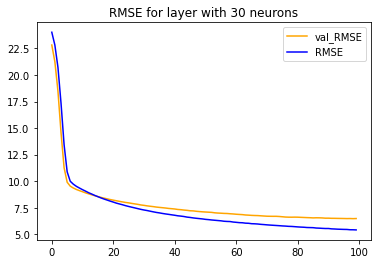

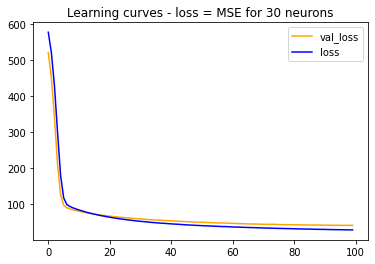

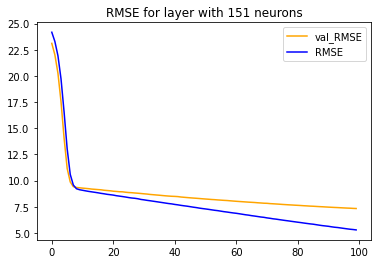

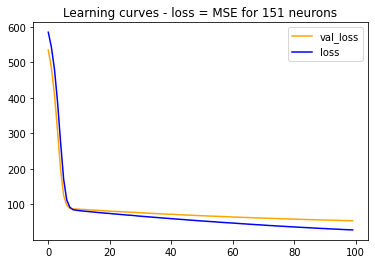

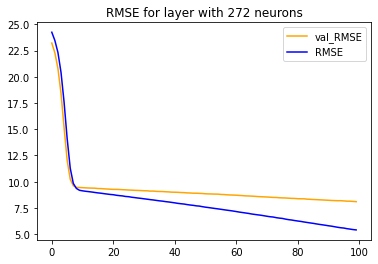

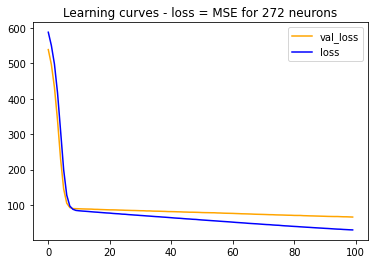

In [ ]:
# define number of nodes in hidden rbf layer
neurons = [int(0.1*Xtrain.shape[0]), int(0.5*Xtrain.shape[0]), int(0.9*Xtrain.shape[0])]

# metrics
R2 = []
MSE = []
MAE = []

R2_train = []
MSE_train = []
MAE_train = []



for num_neurons in neurons:
  # training Rbf Layer and transforming the data sets 
  c, sigma = find_c_sigma(num_neurons,Xtrain)
  # transorm the data
  Xtrain_transformed=rbf_layer(num_neurons, Xtrain, c, sigma)
  Xval_transformed=rbf_layer(num_neurons, Xval, c, sigma)

  # fully connected part
  model = Sequential()
  model.add(Dense(128, activation='relu',input_shape=(num_neurons,))) 
  model.add(Dense(1, activation='linear')) # output layer
  model.compile(loss=keras.losses.MeanSquaredError(), optimizer = keras.optimizers.SGD(learning_rate=0.001), metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])
  # train fully connected part and evaluate in validation data
  history = model.fit(Xtrain_transformed,ytrain, batch_size = 32, epochs = 100, validation_data = (Xval_transformed,yval)) 

  # plots
  plt.figure() 
  plt.title('RMSE for layer with '+str(num_neurons)+' neurons')
  plt.plot(history.history['val_RMSE'],color='orange')
  plt.plot(history.history['RMSE'],color='blue')
  plt.legend(['val_RMSE', 'RMSE'])

  plt.figure()
  plt.title('Learning curves - loss = MSE for '+str(num_neurons)+ ' neurons')
  plt.plot(history.history['val_loss'], color='orange')
  plt.plot(history.history['loss'], color='blue')
  plt.legend(['val_loss', 'loss'])

  # evaluation of model in unseen test data
  # test data first transformed by rbf layer
  Xtest_transformed=rbf_layer(num_neurons, Xtest, c, sigma)
  # then data reach the fully connected part

  ypred = model.predict(Xtest_transformed) # prediction of model
  pred_train = model.predict(Xtrain_transformed) # prediction of model on train data to check overfitting/underfitting

  R2.append(r2_score(ytest,ypred))
  MSE.append(mean_squared_error(ytest,ypred))
  MAE.append(mean_absolute_error(ytest,ypred))

  R2_train.append(r2_score(ytrain,pred_train))
  MSE_train.append(mean_squared_error(ytrain,pred_train))
  MAE_train.append(mean_absolute_error(ytrain,pred_train))


for i in range(len(neurons)):
  print("\nTotal number of neurons in rbf layer = ",neurons[i])
  print("\nEvaluation of model on test set: R2 = "+str(R2[i])+", RMSE = "+str(math.sqrt(MSE[i]))+", MAE = "+str(MAE[i])+", MSE = "+str((MSE[i]))+"")
  print("\n model predictions on train set: R2 = "+str(R2_train[i])+", RMSE = "+str(math.sqrt(MSE_train[i]))+", MAE = "+str(MAE_train[i])+", MSE = "+str((MSE_train[i]))+"")
  

